In [2]:
import pandas as pd
import os
import matplotlib.pylab as pl
import matplotlib.ticker as ticker
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [292]:
# Import data from Zillow's market research
# More information here: https://www.zillow.com/research/data/#rental-data
# This is time-series data for monthly median rent by neighborhood
df = pd.read_csv('http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_Zri_AllHomesPlusMultifamily.csv')

In [293]:
# Selection of 30 well-known neighborhoods across boroughs
nyc_nabes = dict.fromkeys(["West Village","Chelsea","Greenwich Village","Gowanus","Midtown","East Village",
               "Upper West Side","Lower East Side","Financial District","DUMBO","Upper East Side",
               "Morningside Heights","Harlem","Brooklyn Heights","Williamsburg","Cobble Hill",
               "Flushing","Greenpoint","Park Slope","Fort Greene",
               "Bedford Stuyvesant","Bushwick","Crown Heights","Bay Ridge","Astoria","St. George",
               "Jackson Heights","Riverdale","East Harlem","Washington Heights"],1)

In [295]:
# Reduce dataframe to New York metro area and those 30 neighborhoods
df = df[((df["Metro"] == "New York")) & (df['RegionName'].map(nyc_nabes) == 1)]

# Correct typo in source data - Brooklyn Heights is in Kings County, not New York
bh_index = df['CountyName'][df['RegionName'] == 'Brooklyn Heights'].index[0]
df.set_value(bh_index,'CountyName','Kings')

df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-11,2010-12,2011-01,...,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09
3,270958,Upper West Side,New York,NY,New York,New York,4,NaN,NaN,NaN,...,3842,3829,3815,3806,3787,3777,3783,3825,3863,3895
6,270957,Upper East Side,New York,NY,New York,New York,7,NaN,NaN,NaN,...,3560,3542,3523,3499,3478,3483,3496,3523,3531,3535
13,198687,Washington Heights,New York,NY,New York,New York,14,NaN,NaN,NaN,...,2627,2639,2650,2651,2641,2635,2637,2654,2672,2681
15,272816,Astoria,New York,NY,New York,Queens,16,NaN,NaN,NaN,...,2294,2289,2289,2298,2298,2297,2295,2300,2307,2304
19,199001,Williamsburg,New York,NY,New York,Kings,20,NaN,NaN,NaN,...,2914,2931,2939,2936,2943,2947,2955,2953,2954,2949


In [296]:
# Unpivot data by date for dates Sep. 2012 or later to capture last five years
df2 = pd.melt(df, 
        id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], 
        value_vars=df.columns[20:],
        var_name = "Date",
        value_name = "Rent")
df2.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,Rent
0,270958,Upper West Side,New York,NY,New York,New York,4,2011-12,3154.0
1,270957,Upper East Side,New York,NY,New York,New York,7,2011-12,2989.0
2,198687,Washington Heights,New York,NY,New York,New York,14,2011-12,1920.0
3,272816,Astoria,New York,NY,New York,Queens,16,2011-12,1715.0
4,199001,Williamsburg,New York,NY,New York,Kings,20,2011-12,2152.0


In [297]:
# Manipulate Date field into proper date for plotting later
df2['Date'] = df2['Date'] + '-01'
df2['Date'] = pd.to_datetime(df2['Date'], format='%Y-%m-%d')

In [298]:
# Generate array of neighborhoods sorted by latest median rent for ordering subplots
sorted_nabe = df2[df2['Date'] == '2017-09-01'].sort_values(by='Rent', ascending = False)['RegionName']

In [299]:
# Formatter function for y-axis
def money_formatter(x, pos):
    return '${:0,d}'.format(int(x))

In [300]:
# Color by borough
color_map = df2[['RegionName', 'CountyName']].drop_duplicates()
color_dict = {'New York':'rebeccapurple', 'Kings':'darkorange', 'Bronx':'lawngreen', 
              'Richmond':'crimson', 'Queens':'dodgerblue'}
color_map['color'] = color_map['CountyName'].map(color_dict)
color_dict = color_map[['RegionName', 'color']].set_index("RegionName").to_dict()['color']

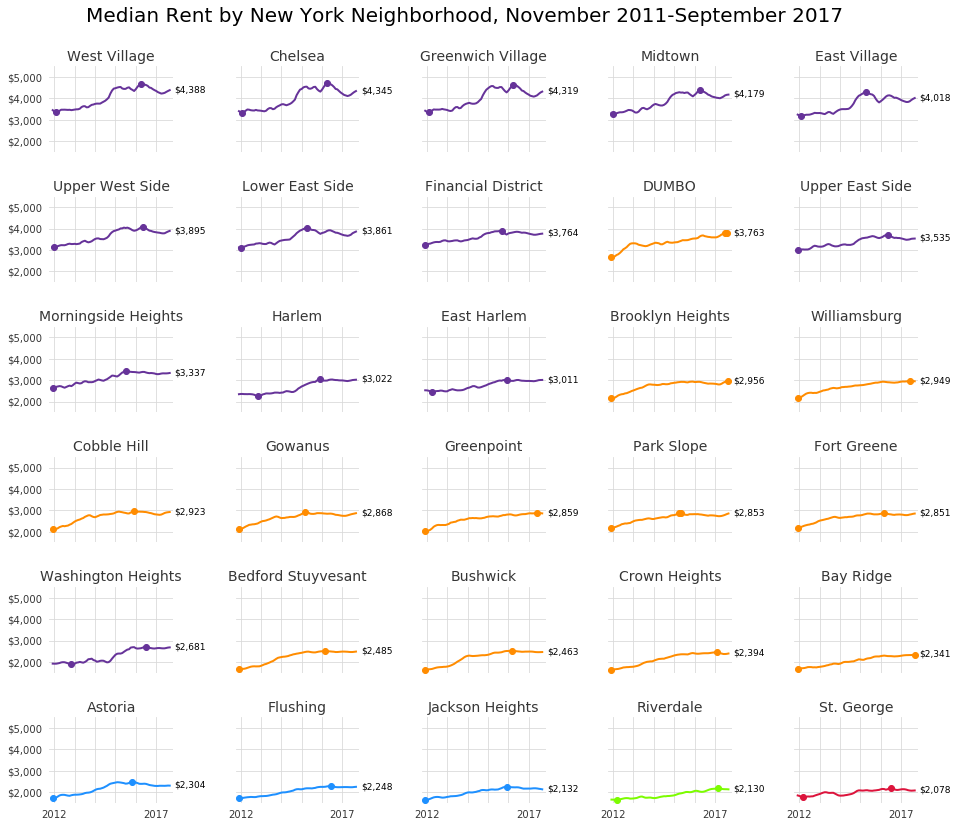

In [302]:
# Plot it
pl.figure(figsize=[13,11])
pl.suptitle('Median Rent by New York Neighborhood, November 2011-September 2017',y=1.04, fontsize=20)

# Subplot for each neighborhood
for n, elem in enumerate(sorted_nabe):
    
    ax = plt.subplot(6,5,n + 1)
    
    df2[df2['RegionName'] == elem].plot(x='Date', y='Rent', ax=ax,legend=False, 
                                        c = color_dict[elem], linewidth=2)
    
    # Get min and max rent per neighborhood and plot as dots on line
    rent_max = df2['Rent'][df2['RegionName'] == elem].max()
    rent_min = df2['Rent'][df2['RegionName'] == elem].min()
    df2[(df2['RegionName'] == elem) & 
        ((df2['Rent'] == rent_max) | (df2['Rent'] == rent_min))].plot(x='Date',y='Rent',ax=ax,legend=False,
                                                                      style='o',c = color_dict[elem])
    
    # Axis limits
    ax.set_ylim(1500,5500)
    ax.set_xlim('2011-10-01', '2017-11-01')
    
    # Subplot title
    ax.set_title(elem, fontsize=14, color = '#363636')
    
    # Lighten grid
    ax.grid(color='#d9d9d9')
    
    # Hide axis ticks
    ax.tick_params(which='minor', bottom='off')
    ax.tick_params(which='major', bottom='off')
    ax.tick_params(which='major', left='off')
    
    # Reduce x-axis tick labels
    ax.set_xticklabels(['2012','','','','', '2017'])
    
    # Remove subplot spines
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Hide x-axis label
    ax.set_xlabel('')
    
    # Format y-axis tick labels to $0,000
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(money_formatter))
    
    # Hide axes based on subplot coordinates
    if n % 5 != 0:
        ax.tick_params(axis='y', colors=(0,0,0,0), labelsize=10)
    else:
        ax.tick_params(axis='y', colors='#363636', labelsize=10)
    if n >= 25:
        ax.tick_params(axis='x', colors='#363636', labelsize=10)
    else:
        ax.tick_params(axis='x', colors=(0,0,0,0), labelsize=10)
        
    # Get latest median rent per neighborhood
    rent_last = df2['Rent'][df2['RegionName'] == elem].iloc[-1]
    
    # Add right-side label for latest median rent
    ax.annotate('$' + str(int(rent_last))[0] + ',' + str(int(rent_last))[1:],
                xy=['2017-09-01', rent_last], xytext=[5,-2], textcoords='offset points', fontsize=9)

# General formatting and output
pl.tight_layout()
pl.savefig("nyc_small_multiples_viz.png", bbox_inches="tight"); 

<b>Figure 1</b>: Median rent for November 2011 - September 2017 for 30 select New York City neighborhoods across the five boroughs. Dots on lines represent the maximum and minimum rent for the period covered. Labels beside points show the latest median rent. 
<br>
<b>Source</b>: Zillow (https://www.zillow.com/research/data/#rental-data).